In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import xgboost as xgb
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from xgboost import plot_importance, plot_tree

In [2]:
# lib configuration
register_matplotlib_converters()
plt.rcParams["figure.figsize"] = (15,8)

Let's try one more time. Compare efectinvess of Tree boosting and ETS models on USD price pridiction 

In [83]:
DATA_PATH = "data/eurusd_hour.csv"

In [84]:
df = pd.read_csv(DATA_PATH)

In [85]:
df.head()

,Date,Hour,BidOpen,BidHigh,BidLow,BidClose,BidChange,AskOpen,AskHigh,AskLow,AskClose,AskChange
0,2002-05-05,19:00,0.9168,0.9168,0.9168,0.9168,0.0,0.9178,0.9178,0.9178,0.9178,0.0
1,2002-05-06,20:00,0.9181,0.9181,0.9181,0.9181,0.0,0.9184,0.9184,0.9184,0.9184,0.0
2,2002-05-07,20:00,0.9152,0.9152,0.9152,0.9152,0.0,0.9155,0.9155,0.9155,0.9155,0.0
3,2002-05-08,20:00,0.9042,0.9042,0.9042,0.9042,0.0,0.9045,0.9045,0.9045,0.9045,0.0
4,2002-05-09,20:00,0.9092,0.9092,0.9092,0.9092,0.0,0.9095,0.9095,0.9095,0.9095,0.0


In [86]:
df['Date'] = pd.to_datetime(df['Date']) # convert to datetime object

In [108]:
df = df[df['Hour'] == '23:00']

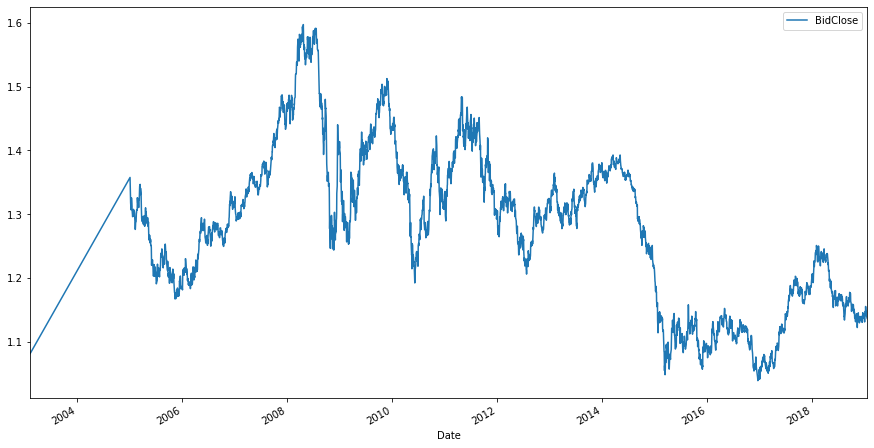

In [109]:
df.plot(x='Date', y='BidClose', figsize=(15,8))

In [110]:
split_date = '2018-12-25'
df_cut = df.loc[df['Date'] >= split_date].copy()

Text(0.5, 1.0, 'Rate of USD to EUR (2017-01-01 to 2019-01-20)')

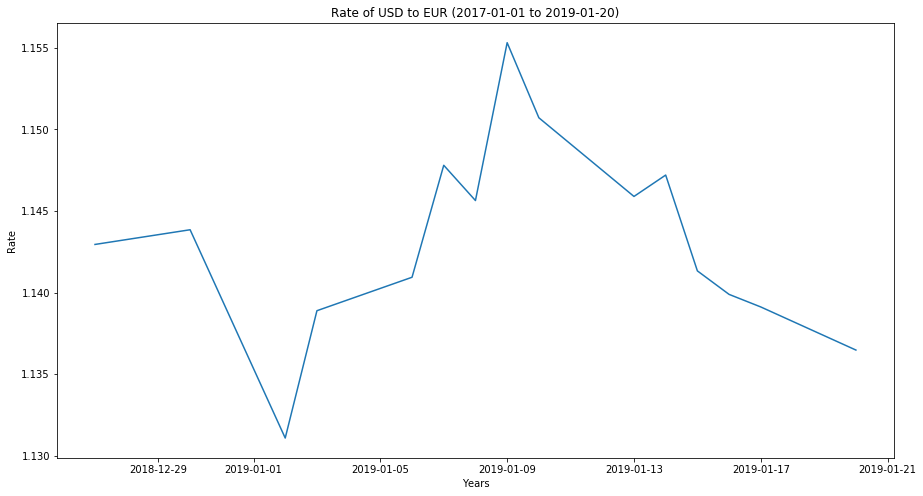

In [111]:
plt.plot(df_cut['Date'], df_cut['BidClose'])
plt.xlabel('Years')
plt.ylabel('Rate')
plt.title("Rate of USD to EUR (2017-01-01 to 2019-01-20)")

In [112]:
train_split = '2019-01-16'
usd_train = df_cut.loc[df_cut['Date'] <= train_split].copy()
usd_test = df_cut.loc[df_cut['Date'] > train_split].copy()

Text(0.5, 1.0, 'Splitted dateset')

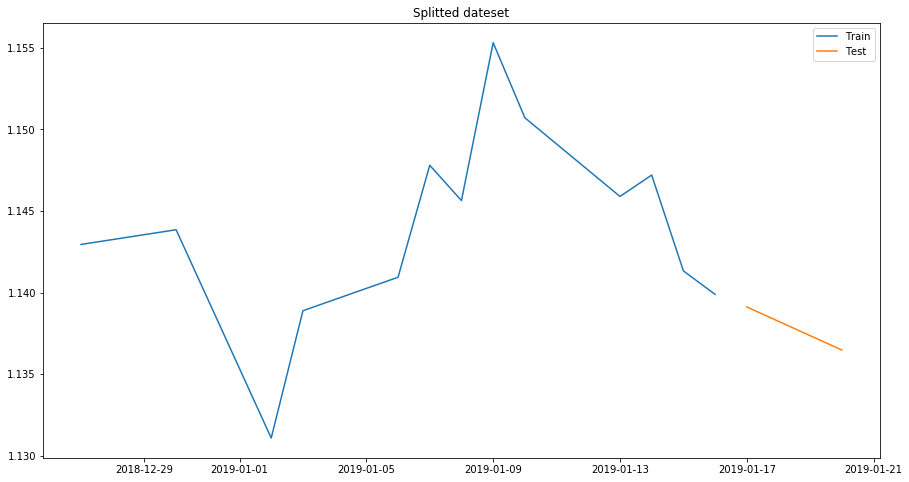

In [113]:
plt.plot(usd_train['Date'], usd_train['BidClose'], label='Train')
plt.plot(usd_test['Date'], usd_test['BidClose'], label='Test')
plt.legend(loc='best')
plt.title("Splitted dateset")

In [114]:
# borrow (with some tweaks) those functions from previous notebook

def create_features_dep(df, x_label='Date', y_label='BidClose'):
    return df[x_label].as_matrix().reshape((-1,1)), df[y_label].as_matrix()


def create_features(df, x_label='Date', y_label='BidClose'):
    # removed year feature, as we are working on 1.5 year sample
    df['hour'] = df[x_label].dt.hour
    df['quarter'] = df[x_label].dt.quarter
    df['month'] = df[x_label].dt.month
    df['dayofyear'] = df[x_label].dt.dayofyear
    df['dayofmonth'] = df[x_label].dt.day
    df['weekofyear'] = df[x_label].dt.weekofyear
    
    X = df[['hour','dayofyear','quarter','month', 'weekofyear', 'dayofmonth']]
    y = df[y_label]

    return X, y

In [115]:
X_train, y_train = create_features(usd_train)
X_test, y_test = create_features(usd_test)

In [317]:
reg = xgb.XGBRegressor(
    colsample_bytree=0.9,
#     subsample=0.5,
    learning_rate=0.1, 
#     max_depth=10, 
    min_child_weight=1.0, 
    n_estimators=250,
#     reg_alpha=0.25, 
#     reg_lambda=0.01, 
#     gamma=0.005, 
#     nthread=-1
)

In [318]:
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=100,
        verbose=False) # too much logs 

[16:57:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1.0, missing=None, n_estimators=250,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0.01,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1.8, missing=None, n_estimators=2000,
             n_jobs=1, nthread=-1, objective='reg:linear', random_state=7,
             reg_alpha=0.1, reg_lambda=0.3, scale_pos_weight=1, seed=None,
             silent=1, subsample=0.5, verbosity=1)

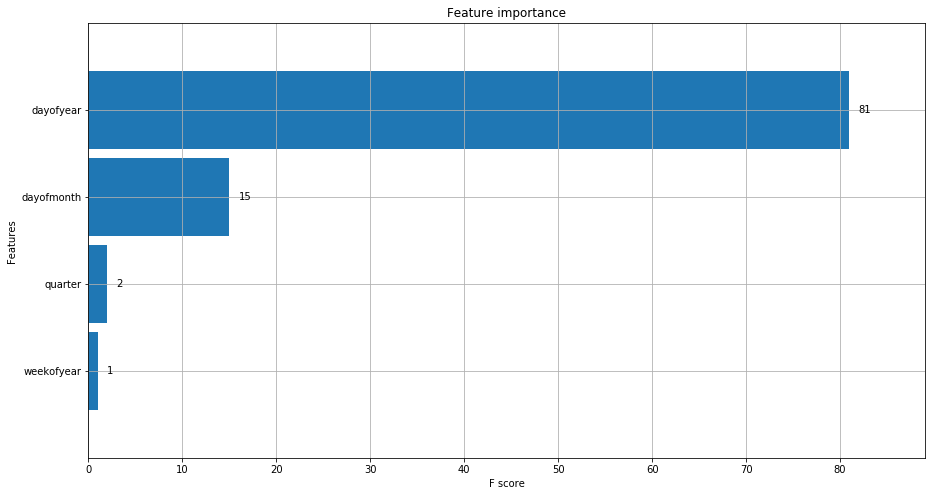

In [319]:
plot_importance(reg, height=0.9)

In [320]:
y_test_predicted = reg.predict(X_test)
usd_test['bid_prediction'] = y_test_predicted

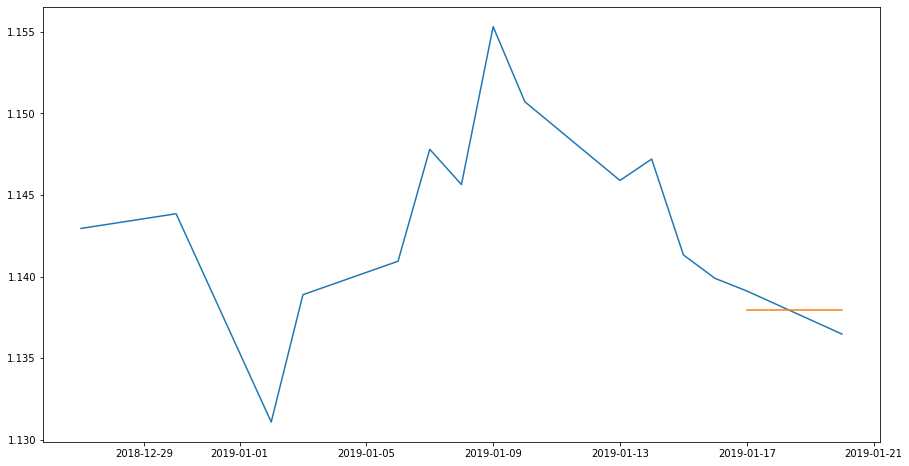

In [321]:
# plot predictions
plt.plot(df_cut['Date'], df_cut['BidClose'])
plt.plot(usd_test['Date'], usd_test['bid_prediction'])

In [322]:
RMSE = np.sqrt(mean_squared_error(y_test, y_test_predicted))

In [323]:
RMSE

0.0013272460577601686

### Forcasting using ETS

In [241]:
y_hat_avg = usd_test.copy()
fit1 = ExponentialSmoothing(np.asarray(usd_train['BidClose']), seasonal_periods=2, trend='add', seasonal='add').fit() 

y_hat_avg['Holt_Winter'] = fit1.forecast(len(usd_test))

/Users/mwos/.pyenv/versions/3.7.2/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


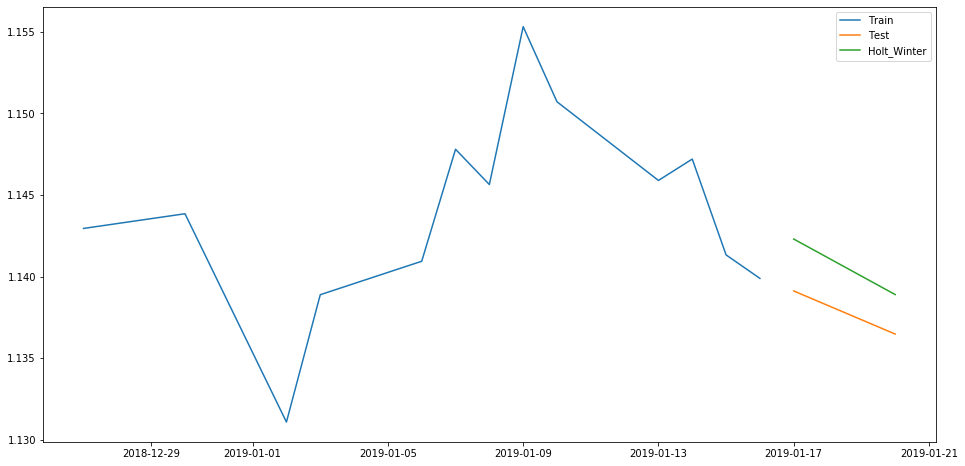

In [242]:
plt.figure(figsize=(16,8))
plt.plot(usd_train['Date'], usd_train['BidClose'], label='Train')
plt.plot(usd_test['Date'], usd_test['BidClose'], label='Test')
plt.plot(usd_test['Date'], y_hat_avg['Holt_Winter'], '-', label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [245]:
RMSE_ETS = np.sqrt(mean_squared_error(usd_test['BidClose'], y_hat_avg['Holt_Winter']))

In [246]:
RMSE_ETS

0.0028260262214638483